In [113]:
%matplotlib widget

# DEFAULTS

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson


FORCES=["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF=[400,450,500,550]

plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 1.6

line_styles = {"LO": {"marker":"d", "markevery": 10, "markersize": 3, "color": "tab:orange"},
               "NLO": {"marker":".", "markevery": 10, "color": "tab:blue"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "tab:green"},
               "N3LO": {"ls": "dotted", "color": "tab:red"},
               "N4LO": {"color": "black"},
               "N4LO+": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "tab:cyan"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "tab:pink"}
              }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"], 
            }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor":"None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "d", "color": "magenta"},
]

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}



df_my = pd.read_csv("Deuteron/deuteron_all_data.csv")
df_exp = pd.read_csv("./Deuteron/deuteron_exp_diffcross.csv")
df_exp_tot = pd.read_csv("./Deuteron/deuteron_exp_totcross.csv")

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in ["THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()
my_energies


# def get_raczek_88():
    # "raczek data with $\theta$=88^deg"
# global df_raczek_T20_88, df_raczek_T22_88, df_arenh_T20_88, df_arenh_T22_88
df_raczek_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T20_88.csv",
                                header=None, skiprows=2,
                                names=["raczek_X", "raczek_Y",
                                        "raczek_errX", "raczek_errY",
                                        "mishev_X", "mishev_Y",
                                        "mishev_errX", "mishev_errY"])
df_raczek_T20_88["raczek_err"] = df_raczek_T20_88["raczek_errY"] - \
    df_raczek_T20_88["raczek_Y"]
df_raczek_T20_88["mishev_err"] = df_raczek_T20_88["mishev_errY"] - \
    df_raczek_T20_88["mishev_Y"]

df_arenh_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T20.csv",
                                header=None, names=["energy", "T20"])

df_raczek_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T22_88.csv",
                                header=None, skiprows=2,
                                names=["raczek_X", "raczek_Y",
                                        "raczek_errX", "raczek_errY",
                                        "mishev_X", "mishev_Y",
                                        "mishev_errX", "mishev_errY"])
df_raczek_T22_88["raczek_err"] = df_raczek_T22_88["raczek_errY"] - \
    df_raczek_T22_88["raczek_Y"]
df_raczek_T22_88["mishev_err"] = df_raczek_T22_88["mishev_errY"] - \
    df_raczek_T22_88["mishev_Y"]

df_arenh_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T22.csv",
                                header=None, names=["energy", "T22"])

rachek_bins = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                             names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                   "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                   "T22", "T22stater", "T22syser"])

rachek_integr = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_egamma.txt",
                            delim_whitespace=True,
                            names=['E-gamma_start', 'E-gamma_end', 'E-gamma_mean', 'Theta-p_start',
                            'Theta-p_end', 'Theta-p_mean', 'T20_value', 'T20_stat_err',
                            'T20_sys_err', 'T21_value', 'T21_stat_err', 'T21_sys_err',
                            'T22_value', 'T22_stat_err', 'T22_sys_err'])
rachek_integr = rachek_integr[rachek_integr["E-gamma_start"] <400]


# Rest

In [3]:
print(OBSERVABLES)

['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


# Differential Cross Section

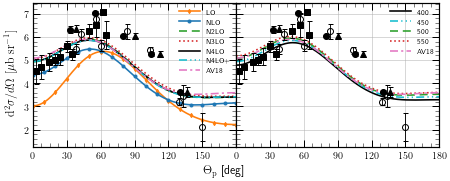

In [47]:
obs="CROSS2"
ylabel="$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"
energy=100

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(6.5, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)
fig.supylabel(ylabel, x=0.03, y=0.6, size=12)
for force in FORCES:
    df_tmp = df_my[(df_my.FORCE == force) & (df_my.CUTOFF == 450) & (df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                 **line_styles[force], label = force)
for cutoff in CUTOFF:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") & (df_my.CUTOFF == cutoff) & (df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[1].plot(df_tmp.angle, df_tmp[obs],
                 **ls_cutoff[cutoff], label = cutoff)
df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == energy)]
for j,ax in enumerate(axes):
    ax.plot(df_av18.angle, df_av18[obs],
                 **line_styles["AV18"], label = "AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == energy].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == energy) & (df_exp.fname == fname)]
        ax.errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax.legend(fontsize=7, handlelength=3)
    ax.tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0,180])
    ax.grid()
fig.tight_layout()
# plt.savefig(f"Figures_python/{obs}_{energy}mev.pdf", dpi=600, facecolor="white")
plt.show()


# Total Cross Section

In [51]:
CROSS_TOT = []
CROSS_TOT_1nc = []
for energy in tqdm(my_energies):
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.Energy == energy) &
                (df_my.WAVE == "SIEGERT")]
    x = df_tmp.THCM.values
    y = df_tmp.CROSS2.values*np.sin(x)
    CROSS_TOT.append(2*np.pi*simpson(y,x=x))
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.Energy == energy) &
                (df_my.WAVE == "1NC")]
    x = df_tmp.THCM.values
    y = df_tmp.CROSS2.values*np.sin(x)
    CROSS_TOT_1nc.append(2*np.pi*simpson(y,x=x))
CROSS_TOT = np.array(CROSS_TOT)
CROSS_TOT_1nc = np.array(CROSS_TOT_1nc)

100%|██████████| 42/42 [00:00<00:00, 97.06it/s] 


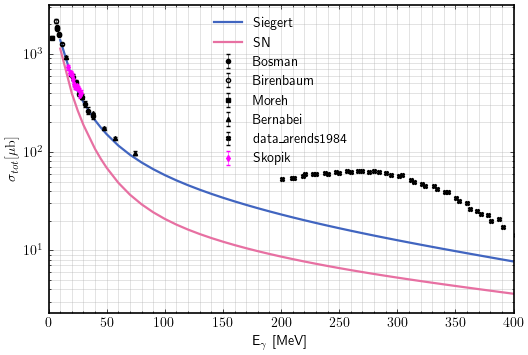

In [63]:
plt.figure(figsize=(6,4))
# plt.figure(figsize=(6.5, 2.8))
plt.plot(energies, CROSS_TOT, label="Siegert")
plt.plot(energies, CROSS_TOT_1nc, label="SN")
marker_common_tmp = {"markersize": 3, "elinewidth": 0.4, "capsize": 1.5}
for i, fname in enumerate(df_exp_tot.fname.unique()):
    df_tmp = df_exp_tot[df_exp_tot.fname == fname]
    plt.errorbar(df_tmp.E, df_tmp.TOTCROSS, yerr=df_tmp.ERR,
    label=fname.split(".")[0].rstrip("data_"),**exp_style[i],**marker_common_tmp)
plt.yscale("log")
plt.ylabel("$\sigma_{tot}[\mu \mathrm{b}]$")
plt.xlabel("E$_\gamma$ [MeV]")
plt.legend()
plt.xlim([0,400])
plt.grid(which='both', alpha=0.5)
plt.savefig(f"Figures_python/TOTAL_CROSSSECTION.pdf", dpi=600, facecolor="white")
plt.show()

# Tensor analyzing power

## Energy distribution

In [75]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.angle == 88) &
                (df_my.WAVE == "SIEGERT")]
df_tmp = df_tmp.sort_values("Energy")

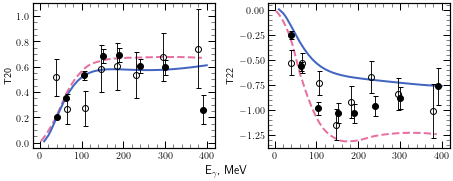

In [76]:
fig, ax = plt.subplots(1,2, figsize=(6.5, 2.8))
fig.supxlabel("E$_\gamma$, MeV", y=0.08, size=12)

ax[0].plot(df_tmp.Energy, df_tmp.T20D2, label="N4LO+", zorder=2, lw=2)
ax[0].plot(df_arenh_T20_88.energy, df_arenh_T20_88.T20, label="arenhovel", ls="dashed", zorder=1, lw=2)
ax[0].errorbar(df_raczek_T20_88.raczek_X, df_raczek_T20_88.raczek_Y, yerr=df_raczek_T20_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[0].errorbar(df_raczek_T20_88.mishev_X, df_raczek_T20_88.mishev_Y, yerr=df_raczek_T20_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[0].legend(fontsize=6)
ax[0].tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
ax[0].tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
ax[0].set_ylabel("T20")

ax[1].plot(df_tmp.Energy, df_tmp.T22D2, label="N4LO+", zorder=2, lw=2)
ax[1].plot(df_arenh_T22_88.energy, df_arenh_T22_88.T22, label="arenhovel", ls="dashed", zorder=1, lw=2)
ax[1].errorbar(df_raczek_T22_88.raczek_X, df_raczek_T22_88.raczek_Y, yerr=df_raczek_T22_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[1].errorbar(df_raczek_T22_88.mishev_X, df_raczek_T22_88.mishev_Y, yerr=df_raczek_T22_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[1].legend(fontsize=6)
ax[1].tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
ax[1].tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
ax[1].set_ylabel("T22", x=20)
# plt.ylabel(

fig.tight_layout()
plt.savefig(f"Figures_python/T20_T22_vs_en.pdf", dpi=600, facecolor="white")
plt.show()

## Angular distribution

In [78]:
rachek_angular = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                             names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                   "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                   "T22", "T22stater", "T22syser"])
rachek_angular["THerr"] = rachek_angular.THmean - rachek_angular.THmin

In [79]:
espans = list(map(lambda x: list(map(lambda x: int(float(x)), x.split())), (rachek_angular.Emin.astype(str) + " " + rachek_angular.Emax.astype(str)).unique()))

In [80]:
espans

[[25, 45],
 [45, 70],
 [70, 100],
 [100, 140],
 [140, 180],
 [180, 230],
 [230, 330],
 [330, 440]]

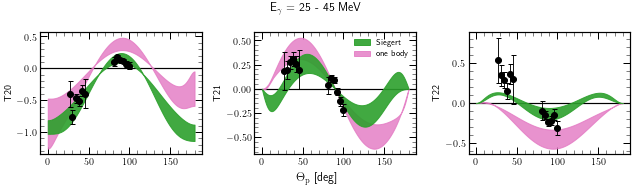

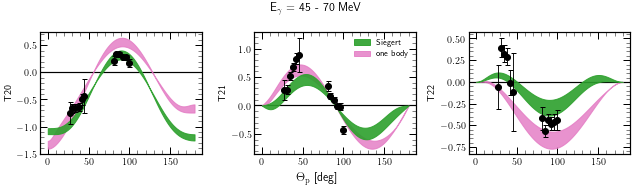

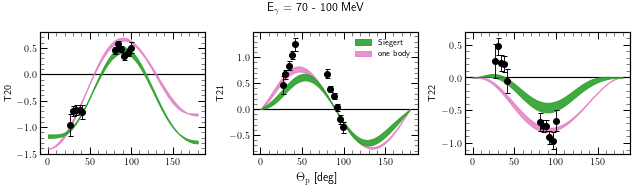

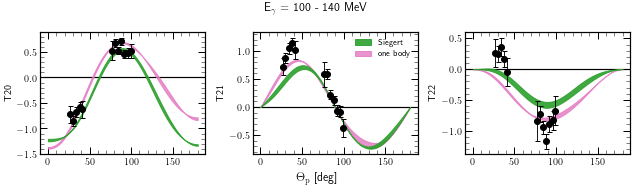

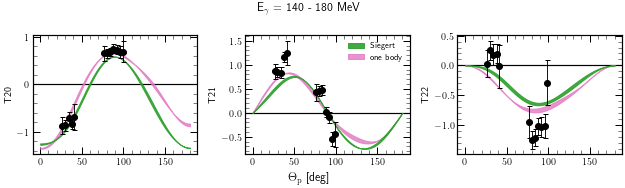

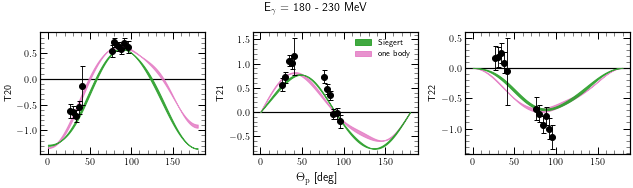

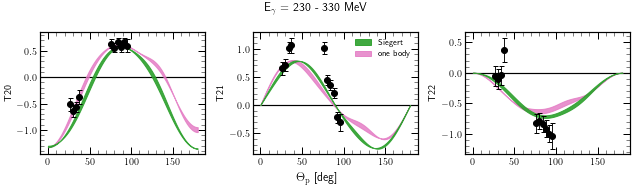

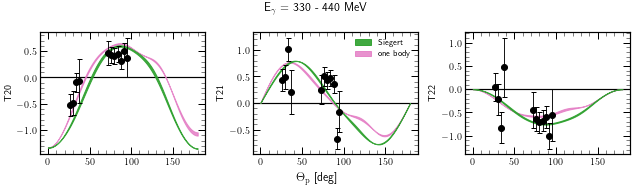

In [84]:
for espan in espans:
    df_sieg = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy >=espan[0]) &
                    (df_my.Energy <= espan[1]) &
                    (df_my.WAVE == "SIEGERT")]
    df_1nc = df_my[(df_my.FORCE == "N4LO+") &
                        (df_my.CUTOFF == 450) &
                        (df_my.Energy >=espan[0]) &
                        (df_my.Energy <= espan[1]) &
                        (df_my.WAVE == "1NC")]
    df_exp = rachek_angular[(rachek_angular.Emin==espan[0]) & (rachek_angular.Emax==espan[1])]
    fig, ax = plt.subplots(1,3, figsize=(9, 2.8))
    fig.suptitle("E$_\gamma$ = {} - {} MeV".format(*espan))
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)

    for i, obs in enumerate(["T20", "T21", "T22"]):

        # Siegert
        df_gr = df_sieg.groupby("angle")[obs+"D2"].agg(['min', 'max']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr,
                        color="tab:green", zorder=3, alpha=0.9, label="Siegert")
        # SN current
        df_gr_1nc = df_1nc.groupby("angle")[obs+"D2"].agg(['min', 'max']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr_1nc,
                        color="tab:pink", zorder=2, alpha=0.8, label="one body")
        # experiment
        ax[i].errorbar(x="THmean", y=obs, yerr=obs + "stater", data=df_exp,
                       zorder=4, label=None, **exp_style[0], **marker_common)

        # style
        ax[i].axhline(c="k", zorder=1, lw=1.2)
        ax[i].set_ylabel(obs)
        # ax[i].yaxis.set_label_coords(-0.15, 0.5)
        ax[i].tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
        ax[i].tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
    ax[1].legend(fontsize=8)
    fig.tight_layout()
    plt.savefig("Figures_python/Tensor_analyzing_power_angular_E{}-{}.pdf".format(*espan), dpi=600, facecolor="white")
    plt.show()

## Integrated

In [126]:
angles = (70, 102)
data={
    "siegert": {
        "min": [],
        "max": [],
        "mean": []
    },
    "1NC": {
        "min": [],
        "max": [],
        "mean": []
    }
}
val_min = []
val_max = []
val_mean = []
val_min_sieg = []
val_max_sieg = []
val_mean_sieg = []
df_local = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.angle >= angles[0]) &
                (df_my.angle <= angles[1])]
for energy in tqdm(my_energies):
    df_tmp = df_local[
        (df_local.Energy == energy) &
        (df_local.WAVE == "1NC") &
    ]
    x = df_tmp.THCM.values
    y = df_tmp.T20D2.values
    val_min.append(np.min(y))
    val_max.append(np.max(y))
    val_mean.append(np.mean(y))
    df_tmp = df_local[
        (df_local.Energy == energy) &
        (df_local.WAVE == "SIEGERT") &
    ]
    x = df_tmp.THCM.values
    y = df_tmp.T20D2.values
    val_min_sieg.append(np.min(y))
    val_max_sieg.append(np.max(y))
    val_mean_sieg.append(np.mean(y))

100%|██████████| 42/42 [00:00<00:00, 67.59it/s]


In [120]:
Eerr=np.array(list(zip(rachek_integr["E-gamma_mean"]-rachek_integr["E-gamma_start"],
                       rachek_integr["E-gamma_end"]-rachek_integr["E-gamma_mean"])))

In [121]:
rachek_integr.head()

,E-gamma_start,E-gamma_end,E-gamma_mean,Theta-p_start,Theta-p_end,Theta-p_mean,T20_value,T20_stat_err,T20_sys_err,T21_value,T21_stat_err,T21_sys_err,T22_value,T22_stat_err,T22_sys_err
0,25.0,45.0,37.2,24.0,48.0,36.1,-0.501,0.040,0.045,0.262,0.037,0.040,0.278,0.053,0.023
1,45.0,70.0,56.1,24.0,48.0,35.3,-0.631,0.040,0.053,0.552,0.036,0.062,0.255,0.053,0.025
2,70.0,100.0,83.7,24.0,44.0,34.8,-0.700,0.047,0.056,0.889,0.044,0.081,0.240,0.064,0.029
3,100.0,140.0,118.7,24.0,44.0,34.1,-0.698,0.051,0.056,0.995,0.049,0.084,0.218,0.072,0.027
4,140.0,180.0,159.2,24.0,44.0,33.4,-0.818,0.064,0.066,0.961,0.058,0.079,0.171,0.085,0.020


In [122]:
Eerr

array([[12.2,  7.8],
       [11.1, 13.9],
       [13.7, 16.3],
       [18.7, 21.3],
       [19.2, 20.8],
       [23.8, 26.2],
       [40.6, 59.4],
       [40.1, 69.9],
       [ 9.8, 10.2],
       [11. , 14. ],
       [13.7, 16.3],
       [17.7, 22.3],
       [19.2, 20.8],
       [24.4, 25.6],
       [41.4, 58.6],
       [41.1, 68.9]])

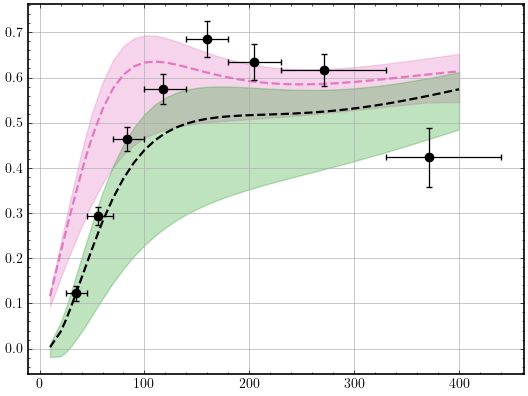

In [123]:
plt.figure()
plt.fill_between(my_energies, val_min, val_max, alpha=0.3, color="tab:pink", zorder=1)
plt.plot(my_energies, val_mean, color="tab:pink", ls="dashed",  zorder=2)
plt.fill_between(my_energies, val_min_sieg, val_max_sieg, alpha=0.3, color="tab:green", zorder=1)
plt.plot(my_energies, val_mean_sieg, color="k", ls="dashed",  zorder=2)
plt.errorbar(x="E-gamma_mean", y="T20_value", yerr="T20_stat_err",
             xerr=Eerr[np.where((rachek_integr["Theta-p_start"]>=70) &
                                (rachek_integr["Theta-p_end"]<=102))].T,
             data=rachek_integr[(rachek_integr["Theta-p_start"]>=70) &
                                 (rachek_integr["Theta-p_end"]<=102)], zorder=2,
             **exp_style[0], **marker_common)
plt.grid()
plt.show()